### This ipython notebook is my work through modeling a fraud detector for a mobile marketplace called GOAT.  For more description please read myBlog.ipy on the same resiprosity.  Note that this is the very cleaned up version of my work on this consulting project!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
from datetime import datetime,timedelta
import warnings
warnings.filterwarnings('ignore')#Many warnings would pop up that clutter our notebook, this commands disables them

order=[]
order = pd.read_csv('order.csv',low_memory=False)

### checking out the labeld data and investigating the percentage of fraud

In [2]:
order.is_potential_fraud.value_counts()

False    105808
True       3483
Name: is_potential_fraud, dtype: int64

#### 3% of the orders taking place on the mobile app are fraudulent!

In [3]:
348300.0/(3483+105808) 

3.1869046856557266

#### Let's exclude the orders that are still pending, because the labels might not be reliable

In [4]:
myTable = []
myTable = order[(order.product_status!='pending')&(order.product_status!='completed')] ### only 4 instances
myTable = myTable.reset_index(drop=True)
print myTable.shape
print order.shape
# so the total number of data we have is less than $110K and 45 features that I have thought could be useful

(109287, 45)
(109291, 45)


In [5]:
myTable['fraud'] = pd.DataFrame(1,index=myTable.index,columns=['fraud'])
myTable.fraud[(myTable.is_potential_fraud) | (myTable.status=='fraudulent')] = 0
len(myTable) - myTable['fraud'].sum()
### some facts
(myTable.status=='fraudulent').groupby(myTable.is_potential_fraud).value_counts()
(myTable.is_potential_fraud).groupby(myTable.status=='fraudulent').value_counts()

status       
False   False    105455
        True       1680
True    True       1803
        False       349
dtype: int64

## Feature Engineering

### the frequency of a deviced used is a good indicator of if an order could be suspicious of fraud

In [6]:
myTable['device']=myTable.groupby(['device_identifier'])['device_identifier'].transform('count')

### indicatin of whethear a user has used his social network (twitter or instagram) account to authenticate his identity

In [7]:
twitter=[]
twitter = pd.DataFrame(0, index=myTable.index, columns = ['twitter'])
twitter[pd.isnull(myTable.twitter_access_token)]=1

instagram=[]
instagram = pd.DataFrame(0, index=myTable.index, columns = ['instagram'])
instagram[pd.isnull(myTable.instagram_access_token)]=1

social=[]
social = pd.DataFrame(twitter.twitter+instagram.instagram, index=myTable.index, columns = ['social'])

### this feature is the time difference from the first activity (first sell or buy) of the user from the time that he has created his account on GOAT mkobile app.  The timestamp is calculated in minutes.
#### Note that for those users with no activity, the timestamp is being set to be equal to the maximum timestamp...

In [8]:
dele=[]
dele = pd.to_datetime(myTable['updated_at'])- pd.to_datetime(myTable['created_at'])
deltaU = dele.dt.total_seconds()/(60000.0)
deltaUU = []
deltaUU = pd.DataFrame(deltaU,index=myTable.index,columns=['timestamp'])
deltaUU[deltaUU<0]=0

dele=[]
dele = pd.to_datetime(myTable['first_purchase_at'])- pd.to_datetime(myTable['created_at'])
deltaT = dele.dt.total_seconds()/(60000.0)
deltaTT = []
deltaTT = pd.DataFrame(deltaT,index=myTable.index,columns=['timestamp_buyer'])
deltaTT = deltaTT.fillna(deltaTT.max())
deltaTT[deltaTT<0]=0

dele=[]
dele = pd.to_datetime(myTable['first_sale_at'])- pd.to_datetime(myTable['created_at'])
deltaS = dele.dt.total_seconds()/(60000.0)
deltaSS = []
deltaSS = pd.DataFrame(deltaS,index=myTable.index,columns=['timestamp_seller'])
deltaSS = deltaSS.fillna(deltaSS.max())
deltaSS[deltaSS<0]=0

### Here I plot the time-difference for both fraudulent and legitimate orders to see how they are distingushed in this univariate space

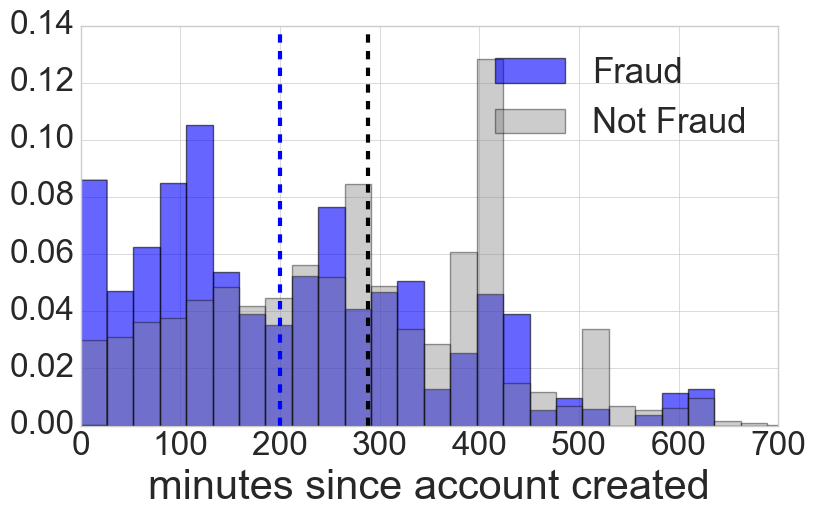

In [9]:
import seaborn.apionly as sns 
sns.set_style("whitegrid")
plt.figure(figsize=(9,5))

myTable['deltaUU'] = deltaUU
bins = np.histogram(myTable['deltaUU'], bins=30)[1] #get the bin edges

weigh1 = np.ones_like(myTable.deltaUU[myTable.fraud==0])/float(len(myTable.deltaUU[myTable.fraud==0]))
weigh2 = np.ones_like(myTable.deltaUU[myTable.fraud==1])/float(len(myTable.deltaUU[myTable.fraud==1]))

plt.hist(myTable['deltaUU'][myTable.fraud==0],weights=weigh1,alpha=0.6,label="Fraud",bins=bins,color='blue')
plt.hist(myTable['deltaUU'][myTable.fraud==1],weights=weigh2,alpha=0.4,label="Not Fraud", bins=bins, color='gray')
plt.axvline((myTable['deltaUU'][myTable.fraud==0]).median(),color='b', linestyle='dashed', linewidth=3)
plt.axvline((myTable['deltaUU'][myTable.fraud==1]).median(),color='k', linestyle='dashed', linewidth=3)
plt.legend()
plt.xlabel('minutes since account created',size=30)
axes = plt.gca()
axes.set_xlim([0,700])
plt.yticks(fontsize=24)
plt.xticks(fontsize=24)
axes.legend(loc = 'upper right',prop={'size':25})
sns.set_style('darkgrid')
plt.show()

### Here we look at the price and how it differs in two types of orders!  Although, counter intuitive, but from the histgram, it seems like the price cannot be used as a distinguishing factor between the fraudulent and not-fraudulent orders

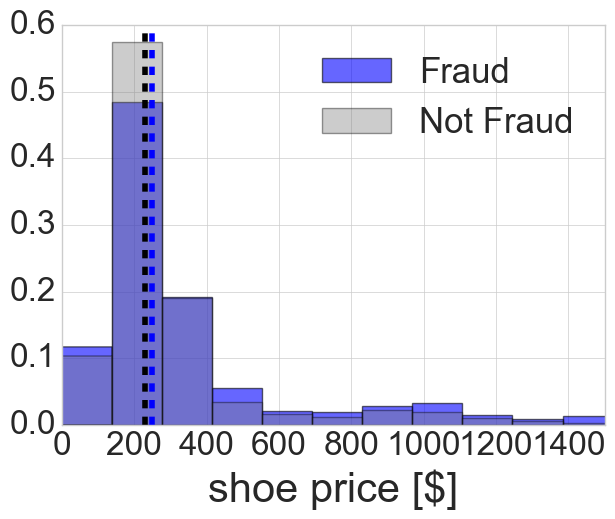

In [11]:
import seaborn.apionly as sns
sns.set_style("whitegrid")
plt.figure(figsize=(7,5))

myTable['price'] = myTable.price_cents/100.0
#myTable['price'][myTable.price<0]=0

weig1 = np.ones_like(myTable.price[myTable.fraud==0])/float(len(myTable.price[myTable.fraud==0]))
weig2 = np.ones_like(myTable.price[myTable.fraud==1])/float(len(myTable.price[myTable.fraud==1]))

cm = plt.cm.get_cmap('RdYlBu_r')
bins=np.histogram(myTable.price, bins=40)[1] #get the bin edges
plt.hist(myTable.price[myTable.fraud==0],weights = weig1,
         alpha=0.6,label="Fraud",bins=bins,color='blue')
plt.hist(myTable.price[myTable.fraud==1], weights = weig2, 
         alpha=0.4,label="Not Fraud", bins=bins, color='gray')
plt.axvline((myTable.price[myTable.fraud==0]).median(),color='b', linestyle='dashed', linewidth=4)
plt.axvline((myTable.price[myTable.fraud==1]).median(),color='k', linestyle='dashed', linewidth=4)

plt.legend()
plt.xlabel('shoe price [$]',size=30)
axes = plt.gca()
axes.set_xlim([0,1500])
plt.yticks(fontsize=24)
plt.xticks(fontsize=24)
axes.legend(loc = 'upper right',prop={'size':25})
sns.set_style('darkgrid')
plt.show()

### the amount of details on the account is a good signification of how legitimate a user behaves on the mobile app

In [12]:
myTable['account_det'] = myTable.groupby(['account_details'])['account_details'].transform('count')
myTable['account_det'] = myTable['account_det'].fillna(0)

### Users' interests in the number of sneakers to buy and sell is also a good indication whether a user is more likely to be involved in a fraudulent act.  The two variables of want_count and own_count record the amount of interest.  Users with more interests in buying or selling are more likely to act legitimately.

In [13]:
myTable.want_count = myTable.want_count.fillna(1.5)
myTable.own_count = myTable.own_count.fillna(1.5)

### here we check if this ip is simillar to the ip that has been used anytime before by this user.  Users with more consistency in their ip are less likely to act fraudulent!

In [14]:
ip = pd.DataFrame(0,index=myTable.index,columns=['IP'])
ip[myTable.current_sign_in_ip==myTable.last_sign_in_ip]=1
ip[myTable.current_sign_in_ip==myTable.current_ip]=1
ip[myTable.last_sign_in_ip==myTable.current_ip]=1
ip[pd.isnull(myTable.current_ip) & pd.isnull(myTable.current_sign_in_ip)]=2

### postal code is trimmed to be compared with zip-code.  3 codes of 0,1 and 2 represent different status of the postal code. If both billing and shipping address have the same zip-code, then it is indicated as 0.  If one of them is not there, it is 2 and in any other case it is 1.  This way, I penalize having different postal code, differently than not having it completed at all!

In [15]:
myTable['zipcode_bill'] = myTable['zipcode_bill'].fillna('00000')
myTable['postal_code'] = myTable['postal_code'].fillna('00000')
myTable['postal_code_part'] = myTable['postal_code'].apply(lambda x: x[0:5])
myTable['zipcode'] = pd.DataFrame(1, index=myTable.index, columns=['zip'])
myTable['zipcode'][myTable['zipcode_bill'] == myTable['postal_code_part']]=0
myTable['zipcode'][(myTable['zipcode_bill'] == '00000') | (myTable['postal_code_part'] == '00000')]=2

In [16]:
# 36% of the orders have the same zip-code
myTable.zipcode.value_counts()

2    69340
0    25944
1    14003
Name: zipcode, dtype: int64

### Here is a table of 14 features that have been engineered throughout this notebook.  The ones that are not discussed explicitely alone, are being considered in a raw format for the classification purpose.

In [17]:
data=[]
data = pd.concat([myTable['points'], myTable['seller_score'],myTable['want_count'], 
                  myTable.template_selling_count, social,instagram,myTable['own_count'],
                  myTable['account_det'], ip, myTable['zipcode'], deltaUU,
                  myTable['device'], myTable['sign_in_count'],myTable['product_id'],
                  myTable.fraud],axis=1)

## Classification

### Before applying any classification model, I split my data to a 75%-25% training and testing splits. Then, I apply a random forest classifier with balanced class weight to train my data.  I also use out of bag cross validation to tune my parameters.

In [19]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

train, test = train_test_split(data,random_state=500,test_size=0.25)
features_train = train.ix[:, train.columns!='fraud']
labels_train = train.fraud
features_test = test.ix[:, test.columns!='fraud']
labels_test = test.fraud

clf_RF = RandomForestClassifier(class_weight='balanced',random_state=5000, oob_score=True)
                               
clf_RF.fit(features_train,labels_train)
print clf_RF.oob_score_

0.975489538218


### For a 0.71 probability threshold, there is a good balance between recall and precision.  The recall could get to 92% by increasing the probability threshold, but, that has the cost of precision dropping to 68%.

In [21]:
from sklearn import metrics

prediction = clf_RF.predict_proba(features_test)
pred = prediction[:,1]>0.71
### optimal threshold
print(roc_auc_score(labels_test,pred))
print(metrics.classification_report(labels_test,pred))
print confusion_matrix(labels_test,pred)  

importances = clf_RF.feature_importances_ 
std = np.std([tree.feature_importances_ for tree in clf_RF.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
X = features_train
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%s"%(X.columns.values[indices[f]]), importances[indices[f]])

0.92531090901
             precision    recall  f1-score   support

          0       0.85      0.86      0.85       995
          1       0.99      0.99      0.99     26327

avg / total       0.99      0.99      0.99     27322

[[  852   143]
 [  149 26178]]
Feature ranking:
('timestamp', 0.15782279890851816)
('own_count', 0.15368794940439984)
('product_id', 0.13216901425100383)
('want_count', 0.096448890355023673)
('template_selling_count', 0.094470224129014679)
('device', 0.093020631725115141)
('zipcode', 0.078442149931719385)
('sign_in_count', 0.059926611124444383)
('points', 0.038147613796814833)
('account_det', 0.029948750131642825)
('seller_score', 0.026069891577503741)
('IP', 0.017829394265121607)
('social', 0.011604314058041906)
('instagram', 0.010411766341636016)


### The feature importance are shown here.  Three of my engineered features are among the first 4 important features!

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0]


(array([ 0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,  0.18]),
 <a list of 10 Text yticklabel objects>)

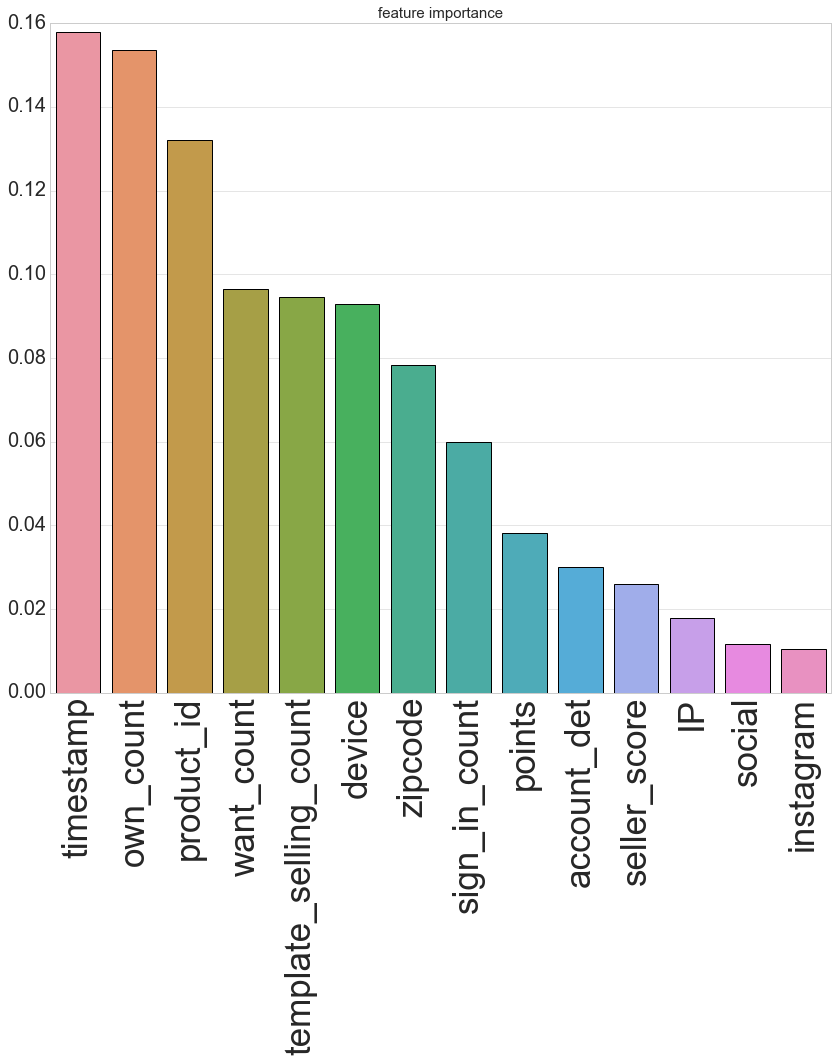

In [54]:
#### plot feature importance
%matplotlib inline
import seaborn.apionly as sns
import seaborn as sns 

num = data.shape[1]
num=14

ind = [i * 1. for i in range(0, num )] 
sns.set_style("whitegrid")
plt.figure(figsize=(14,12))
sns.barplot(ind,importances[indices[:num]])
plt.xticks(rotation=90)
plt.xticks(fontsize=20)
print ind
plt.xticks(ind,X.columns.values[indices[:num]],fontsize=35)
plt.title("feature importance", fontsize=15)
plt.yticks(fontsize=20)

## the area under the ROC curve is about 96% which is very impressing

0.961184659958


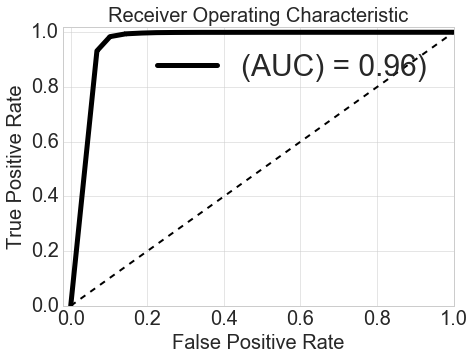

In [55]:
fpr, tpr,_ = roc_curve(labels_test, prediction[:,1])
roc_auc = auc(fpr, tpr)
print roc_auc

%matplotlib inline
import seaborn.apionly as sns
#import seaborn as sns 
sns.set_style("whitegrid")
plt.figure(figsize=(7,5))
plt.title('Receiver Operating Characteristic',size=20)
plt.plot(fpr, tpr, lw=5, color='k', label='(AUC) = %0.2f)' % roc_auc)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(loc = 'bottom right',prop={'size':30})
plt.plot([0, 1], [0, 1],'k--', linewidth=2)
plt.xlim([-0.02, 1.])
plt.ylim([-0.0, 1.02])
plt.ylabel('True Positive Rate',size=20)
plt.xlabel('False Positive Rate',size=20)
sns.set_style('darkgrid')
#sns.set_style("ticks", {"xtick.major.size": 18, "ytick.major.size": 18})
plt.show()